In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from odo import odo
from quantopian.interactive.data.zacks import earnings_surprises

# Import Pipeline class and datasets
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits

# Import built-in moving average calculation
from quantopian.pipeline.factors import SimpleMovingAverage

# Import built-in trading universe
from quantopian.pipeline.experimental import QTradableStocksUS

# Import run_pipeline method
from quantopian.research import run_pipeline


In [2]:
def get_earnings(start, end, value_threshold, positive, data_provider):
    
    if positive:
        # Positive earnings surprises
        temp_data = earnings_surprises[earnings_surprises.eps_pct_diff_surp >= value_threshold]
    else:
        # Negative earnings surprises
        temp_data = earnings_surprises[earnings_surprises.eps_pct_diff_surp <= value_threshold * -1]
        
    temp_data = temp_data[temp_data.asof_date >= pd.to_datetime(start)]
    temp_data = temp_data[temp_data.asof_date <= pd.to_datetime(end)]
    df = odo(temp_data, pd.DataFrame)
    df = df[['symbol', 'asof_date', 'eps_pct_diff_surp']]
    df = df[df['symbol'].isin(data_provider.symbols_universe)]
    df = df.dropna()
    
    return df


In [3]:
def build_events(start, end, value_threshold, positive, data_provider):

    """Return a pandas dataframe of the events formated in away the EventStudy can handle it."""

    event_list_df = get_earnings(start, end, value_threshold, positive, data_provider)
    
    event_list_df.rename(columns={'symbol': 'ticker', 'asof_date': 'day_0_date'}, inplace=True)
    
    # convert date strings to datetimes
    event_list_df['day_0_date'] =  pd.to_datetime(event_list_df['day_0_date'])
    
    # Add index and sort by date
    event_list_df = event_list_df.set_index('day_0_date')
    event_list_df = event_list_df.sort_index()
    #print(event_list_df)
    #print(event_list_df.loc['2001':'2002'])

    # Drop events before 2002 (when Quantopian data starts)
    event_list_df = event_list_df.truncate('2002')

    # Reset index so day_0_date is a column again
    event_list_df = event_list_df.reset_index()

    return event_list_df


In [4]:
class DataProvider(object):

    def __init__(self):
        pass

    """Provide security price data specifically for this event study."""

    def get_event_window_columns(self, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a list of column headers for the event window. Ex: ['-2','-1','0','1','2']"""

        cols = []
        for i in range(num_pre_event_window_periods * -1, num_post_event_window_periods + 1):
            cols.append(str(i))

        return cols

    def get_closing_prices(self, ticker, day_0_date, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a pandas DataFrame of closing prices over the event window."""

        """
        
        Returns:
            pandas DataFrame, empty if no data was available. If there was data available, the 
        """

        raise NotImplementedError('subclasses must override foo()!')

In [5]:
class DataProviderQuantopian(DataProvider):

    """Provide security price data specifically for this event study."""

    def __init__(self, start, end):
        self.make_pipeline()
        self.get_liquid_universe_of_stocks(start, end)
    
    def make_pipeline(self):
        # Create a reference to our trading universe
        base_universe = QTradableStocksUS()

        # Get latest closing price
        close_price = USEquityPricing.close.latest

        # Return Pipeline containing close_price and
        # sentiment_score that has our trading universe as screen
        self.my_pipeline = Pipeline(
            columns={
                'close_price': close_price
            },
            screen=base_universe
        )
    
    def get_liquid_universe_of_stocks(self, start_date, end_date):    
        """
        Gets the top X number of securities based on the criteria defined in
        `filter_universe`

        Parameters
        ----------
        start_date : string or pd.datetime
            Starting date for universe computation.
        end_date : string or pd.datetime
            End date for universe computation.

        Returns
        -------
        security_universe : list
            List of securities that match the universe criteria
        """

        # Execute pipeline created by make_pipeline
        # between start_date and end_date
        pipeline_output = run_pipeline(
            self.my_pipeline,
            start_date=start_date,
            end_date=end_date
        )
        
        self.security_universe = pipeline_output.index.levels[1].unique().tolist()
        
        self.symbols_universe = []
        for equity in self.security_universe:
            self.symbols_universe.append(equity.symbol)
        
        return self.security_universe


    def get_closing_prices(self, ticker, day_0_date, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a pandas DataFrame of closing prices over the event window."""

        # prep the return value
        columns = self.get_event_window_columns(num_pre_event_window_periods, num_post_event_window_periods)
        closing_prices_df = pd.DataFrame(index=[0], columns=columns)
        prices = [np.nan for i in range(num_pre_event_window_periods + 1 + num_post_event_window_periods)]
        closing_prices_df.loc[0] = prices

        # The periods are trading days, but yahoo requires start and end dates.
        # We want to make sure we cover the event window so be conservative with our data pulling here so
        # triple it.
        pre_window_delta = num_post_event_window_periods * 3
        post_window_delta = num_post_event_window_periods * 3

        start_date = day_0_date - dt.timedelta(days=pre_window_delta)
        end_date = day_0_date + dt.timedelta(days=post_window_delta)
        #print('ticker: {}, day_0_date: {}, start_date: {}, end_date: {}'.format(ticker, day_0_date, start_date, end_date))
            
        # Get a pandas dataframe of closing prices
        try:
            data_df = get_pricing(
                ticker,
                fields='close_price', #modify to price, open_price, high, low or volume to change the field
                start_date=start_date, #customize your pricing date range
                end_date = end_date, 
                frequency='daily', #change to minute for minute pricing,
                handle_missing='ignore'
            )
        except Exception as e:
            return closing_prices_df
            
        #print(data_df.head())

        if data_df.isnull().values.any():
            # Return an empty dataframe if any of the data is NaN
            return closing_prices_df
        elif data_df.empty:
            # Return an empty dataframe if we didn't get anything
            return closing_prices_df

        # Find the index of the event at day 0
        index = data_df.index.searchsorted(day_0_date)

        # Get the prices for the event window
        event_window_start = index-num_pre_event_window_periods
        event_window_end = index+num_post_event_window_periods+1
        prices = data_df.iloc[event_window_start:event_window_end]

        if len(columns) != len(prices):
            #print('cols = {}, prices = {}'.format(len(columns), len(prices)))
            # Return an empty dataframe if we didn't get enough data
            return closing_prices_df

        # Set them in the dataframe we are returning
        closing_prices_df.loc[0] = prices.values

        return closing_prices_df

In [6]:
class EventStudyResults(object):

    """Helper class that collects and formats the event study results.

    Attributes:
        num_starting_events (int): The number of events in the event list passed into the event study.
        num_events_processed (int): The number of events that made it into the final calculations.
        aar (pandas.Series): The average abnormal returns from the event study in a pandas.Series. The index of the
            series goes from [event_window_start : event_window_end]. ie:
                ['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6']
            The values of the Series are float64. The first value will be a nan  since these are returns
            calculated from the previous value. ie:
                [nan, -0.00029537, 0.00117336, 0.00569039, 0.00568463, -0.01591504, -0.0294841, -0.00043875,
                0.0047285, 0.00226918, 0.01414965, 0.00387815, -0.00431594]
        caar (pandas.Series): The cumulative average abnormal returns from the event study in a pandas.Series.
            The index of the series goes from [event_window_start : event_window_end]. ie:
                ['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6']
            The values of the Series are float64. The first value will be a nan  since these are returns
            calculated from the previous value. ie:
                [nan, -0.00029537, 0.00087799, 0.00656838, 0.01225301, -0.00366204, -0.03314613, -0.03358488,
                -0.02885638, -0.0265872, -0.01243755, -0.0085594, -0.01287535]

    """

    def __init__(self):
        self.num_starting_events = 0
        self.num_events_processed = 0
        self.aar = None
        self.caar = None
        self.std_err = None

    def plot_simple(self, title=None, show_errorbar=False):
        plt.clf()
        plt.figure(1)
        box_props = dict(facecolor='w', alpha=1.0)

        ax1 = plt.subplot(211)
        plt.title(title)
        ax1.grid(color='k', linestyle='--', linewidth=.5)
        plt.ylabel('CAAR (%)')
        plt.plot(self.caar, label="N=%s" % self.num_events_processed)
        vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:1.2f}%'.format(x*100) for x in vals])
        caar_std_dev = self.caar.std()
        if show_errorbar:
            plt.errorbar(self.caar.index, self.caar, yerr=caar_std_dev,
                         linestyle='None', elinewidth=1, ecolor='#1f77b4', capsize=2)
        plt.legend(loc='upper right')
        textstr = 'Day 0: {0:.2f}%\nStd: {1:.3f}'.format(self.caar.loc['0'] * 100, caar_std_dev)
        ax1.text(0.02, 0.05, textstr, transform=ax1.transAxes, verticalalignment='bottom', bbox=box_props)

        ax2 = plt.subplot(212)
        ax2.grid(color='k', linestyle='--', linewidth=.5)
        plt.plot(self.aar, label="N=%s" % self.num_events_processed)
        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:1.2f}%'.format(x*100) for x in vals])
        aar_std_dev = self.aar.std()
        if show_errorbar:
            plt.errorbar(self.aar.index, self.aar, yerr=aar_std_dev,
                         linestyle='None', elinewidth=1, ecolor='#1f77b4', capsize=2)
        plt.legend(loc='upper right')
        textstr = 'Day 0: {0:.2f}%\nStd: {1:.3f}'.format(self.aar.loc['0'] * 100, aar_std_dev)
        ax2.text(0.02, 0.05, textstr, transform=ax2.transAxes, verticalalignment='bottom', bbox=box_props)
        plt.ylabel('AAR (%)')
        plt.xlabel('Event Window')

        plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
        plt.show()


In [7]:
class EventStudyNaiveModel(object):
    
    """Tool that runs an event study, calculating CAAR using the naive benchmark model."""

    def __init__(self, data_provider, event_list_df):
        """Create an event study.

        Args:
            data_provider (:obj:`EventStudyESFR`): object that gets security data
            event_list_df (:obj:`DataFrame`): Pandas DataFrame containing the list of event dates and ticker symbols.
            The ticker symbol must be in a column 'ticker'.
            For daily data, the date of day 0 must be column 'day_0_date' as a ISO8601 string (ie: YYYY-MM-DD)
        """

        self.data_provider = data_provider
        self.event_list_df = event_list_df
        self.num_pre_event_window_periods = 0
        self.num_post_event_window_periods = 0
        self.results = None

        pass

    def run_naive_model(self, market_ticker, num_pre_event_window_periods, num_post_event_window_periods):
        """Run the event study using the naive benchmark model and return the results.

        Args:
            market_ticker (str): The ticker of the model's benchmark
            num_pre_event_window_periods (int): The number of periods before the event
            num_post_event_window_periods (int): The number of periods after the event

        Returns:
            An instance of EventStudyResults.

        """

        self.results = EventStudyResults()
        self.num_pre_event_window_periods = num_pre_event_window_periods
        self.num_post_event_window_periods = num_post_event_window_periods

        # Create a DataFrame to hold all the Abnormal Returns which will be used
        # to calculate the Average Abnormal Return (AAR)
        columns = self.data_provider.get_event_window_columns(num_pre_event_window_periods,
                                                              num_post_event_window_periods)
        all_abnormal_returns_df = pd.DataFrame(columns=columns)
        #print('\nAll Abnormal Returns: \n{}'.format(all_abnormal_returns_df))

        for index, event in self.event_list_df.iterrows():

            """
            For each event:
                Get the closing prices of the securities for the event window
                Get the closing prices of the market benchamark for the event window
                Calculate the actual returns for the security.
                Calculate the market returns (ie: normal returns) for the benchmark.
                Calculate the abnormal return.
                Calculate the average abnormal return.
                Calculate the cumulative average abnormal return.
            """

            #print('\nDay Zero Date: {} ticker: {}'.format(event.day_0_date, event.ticker))

            # Get prices for the security over the event window
            security_prices_df = self.data_provider.get_closing_prices(event.ticker,
                                                                      event.day_0_date,
                                                                      self.num_pre_event_window_periods,
                                                                      self.num_post_event_window_periods)

            if security_prices_df.isnull().values.any():
                print('\n**** Prices for {} are missing around date: {} ****'.format(event.ticker, event.day_0_date))
                continue

            #print('\nSecurity prices($) for {} over the event window:\n{}'.format(event.ticker, security_prices_df.to_string(index=False)))

            # Get prices for the market benchmark over the event window
            market_prices_df = self.data_provider.get_closing_prices(market_ticker,
                                                                    event.day_0_date,
                                                                    self.num_pre_event_window_periods,
                                                                    self.num_post_event_window_periods)

            if market_prices_df.isnull().values.any():
                print('\n**** Prices for {} are missing around date: {} ****'.format(market_ticker, event.day_0_date))
                continue

            #print('\nMarket prices($) for {} over the event window:\n{}'.format(market_ticker, market_prices_df.to_string(index=False)))

            # Calculate the actual arithmetic return for the security over the event window
            actual_returns_df = security_prices_df.pct_change(axis='columns')
            #print('\nSecurity Returns(%) for {} over the event window::\n{}'.format(event.ticker,(actual_returns_df*100).round(2).to_string(index=False)))

            # Calculate the arithmetic return for the market over the event window.
            # In the naive model, this becomes the Normal Return.
            normal_returns_df = market_prices_df.pct_change(axis='columns')
            #print('\nNormal Returns(%) for {} over the event window:\n{}'.format(market_ticker,(normal_returns_df*100).round(2).to_string(index=False)))

            # Calculate the Abnormal Return over the event window
            # AR = Stock Return - Normal Return
            abnormal_returns_df = actual_returns_df.sub(normal_returns_df)
            #print('\nAbnormal Returns(%) for {} over the event window:\n{}'.format(event.ticker,(abnormal_returns_df*100).round(2).to_string(index=False)))

            # Append the AR to the other ARs so we can calculate AAR later
            all_abnormal_returns_df = pd.concat([all_abnormal_returns_df, abnormal_returns_df], ignore_index=True)
            
            print('Processed event: {} day_0_date: {} ticker: {} surprise: {}'.format(index, 
                                                                                      event.day_0_date, 
                                                                                      event.ticker,
                                                                                     event.eps_pct_diff_surp))

        #print('\nAR(%) for all securities over the event window:\n{}'.format((all_abnormal_returns_df*100).round(2)))
        # Calculate the Average Abnormal Returns (AAR)
        aar = all_abnormal_returns_df.mean()
        #print('\nAAR(%) for all the securities over the event window:\n{}'.format((aar*100).round(2).to_frame().T.to_string(index=False)))

        # Calculate the Cumulative Average Abnormal Returns
        caar = aar.cumsum()
        #print('\nCAAR(%) for all the securities over the event window:\n{}'.format((caar * 100).round(2).to_frame().T.to_string(index=False)))

        self.results.aar = aar
        self.results.caar = caar
        self.results.num_starting_events = self.event_list_df.shape[0]
        self.results.num_events_processed = all_abnormal_returns_df.shape[0]

        return self.results


In [8]:
def negative_earnings():

    """
    This event study shows what happens to airline security prices after a plane crash.
    """
    
    start = '2018-01-01'
    end =  '2018-06-01'
    value_threshold = 100.0
    positive = False
    
    data_provider = DataProviderQuantopian(start, end)

    event_list_df = build_events(start, end, value_threshold, positive, data_provider)
    print('The event list has {} events.\n'.format(event_list_df.shape[0]))

    event_study = EventStudyNaiveModel(data_provider, event_list_df)

    # Run the event study looking 6 periods before the event and 6 periods after the event
    num_pre_event_window_periods = num_post_event_window_periods = 6
    market_ticker = 'SPY'
    results = event_study.run_naive_model(market_ticker, num_pre_event_window_periods, num_post_event_window_periods)

    print('\nStarted with {} events and processed {} events.'.format(results.num_starting_events,
                                                                    results.num_events_processed))

    print('\nAAR (%) for all the securities over the event window:\n{}'.format(
        (results.aar * 100).round(2).to_frame().T.to_string(index=False)))

    print('\nCAAR (%) for all the securities over the event window:\n{}'.format(
        (results.caar * 100).round(2).to_frame().T.to_string(index=False)))

    results.plot_simple('Negative earning surprises and their impact on stock returns')


In [9]:
def positive_earnings():

    """
    This event study shows what happens to airline security prices after a plane crash.
    """
    
    start = '2018-01-01'
    end =  '2018-06-01'
    value_threshold = 100.0
    positive = True
    
    data_provider = DataProviderQuantopian(start, end)

    event_list_df = build_events(start, end, value_threshold, positive, data_provider)
    print('The event list has {} events.\n'.format(event_list_df.shape[0]))

    event_study = EventStudyNaiveModel(data_provider, event_list_df)

    # Run the event study looking 6 periods before the event and 6 periods after the event
    num_pre_event_window_periods = num_post_event_window_periods = 6
    market_ticker = 'SPY'
    results = event_study.run_naive_model(market_ticker, num_pre_event_window_periods, num_post_event_window_periods)

    print('\nStarted with {} events and processed {} events.'.format(results.num_starting_events,
                                                                    results.num_events_processed))

    print('\nAAR (%) for all the securities over the event window:\n{}'.format(
        (results.aar * 100).round(2).to_frame().T.to_string(index=False)))

    print('\nCAAR (%) for all the securities over the event window:\n{}'.format(
        (results.caar * 100).round(2).to_frame().T.to_string(index=False)))

    results.plot_simple('Positive earning surprises and their impact on stock returns')


The event list has 44 events.

Processed event: 0 day_0_date: 2018-01-18 00:00:00 ticker: TEAM surprise: -133.33
Processed event: 1 day_0_date: 2018-01-25 00:00:00 ticker: TMST surprise: -126.47
Processed event: 2 day_0_date: 2018-01-31 00:00:00 ticker: NOW surprise: -283.33
Processed event: 3 day_0_date: 2018-02-01 00:00:00 ticker: GPRO surprise: -184.62
Processed event: 4 day_0_date: 2018-02-06 00:00:00 ticker: SPSC surprise: -133.33
Processed event: 5 day_0_date: 2018-02-07 00:00:00 ticker: WTM surprise: -244.12
Processed event: 6 day_0_date: 2018-02-08 00:00:00 ticker: PENN surprise: -121.05
Processed event: 7 day_0_date: 2018-02-08 00:00:00 ticker: GLUU surprise: -166.67
Processed event: 8 day_0_date: 2018-02-08 00:00:00 ticker: MTW surprise: -150.0
Processed event: 9 day_0_date: 2018-02-13 00:00:00 ticker: UAA surprise: -100.0
Processed event: 10 day_0_date: 2018-02-13 00:00:00 ticker: LSCC surprise: -200.0
Processed event: 11 day_0_date: 2018-02-14 00:00:00 ticker: TRIP surprise

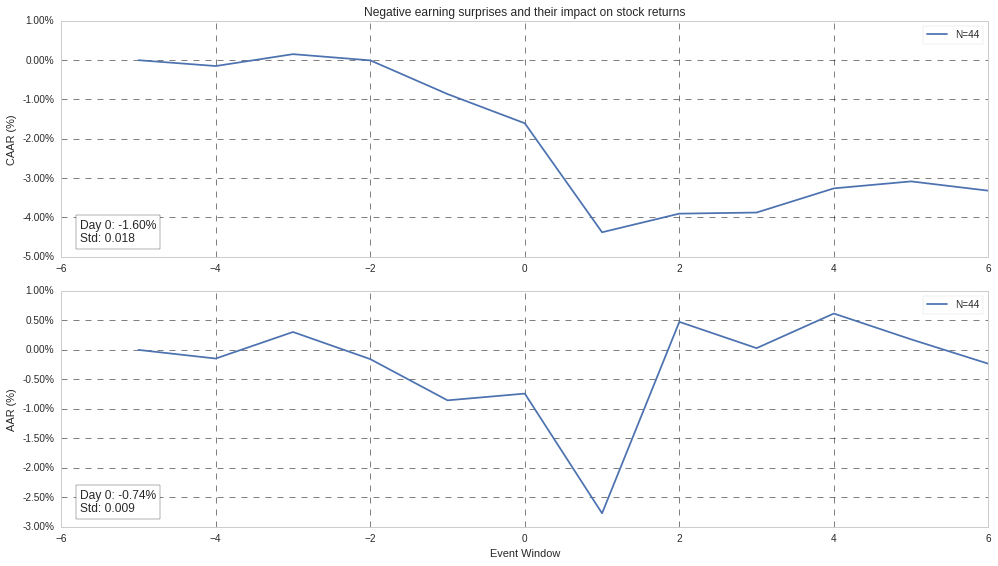

In [19]:
negative_earnings()

The event list has 84 events.

Processed event: 0 day_0_date: 2018-01-04 00:00:00 ticker: RAD surprise: 100.0
Processed event: 1 day_0_date: 2018-01-17 00:00:00 ticker: ADTN surprise: 225.0
Processed event: 2 day_0_date: 2018-01-24 00:00:00 ticker: HZO surprise: 2400.0
Processed event: 3 day_0_date: 2018-01-29 00:00:00 ticker: FBP surprise: 116.67
Processed event: 4 day_0_date: 2018-01-30 00:00:00 ticker: CNX surprise: 266.67
Processed event: 5 day_0_date: 2018-01-30 00:00:00 ticker: AMD surprise: 200.0
Processed event: 6 day_0_date: 2018-01-31 00:00:00 ticker: OTEX surprise: 333.33
Processed event: 7 day_0_date: 2018-01-31 00:00:00 ticker: MUR surprise: 300.0
Processed event: 8 day_0_date: 2018-01-31 00:00:00 ticker: QNST surprise: 200.0
Processed event: 9 day_0_date: 2018-02-01 00:00:00 ticker: LPLA surprise: 140.54
Processed event: 10 day_0_date: 2018-02-01 00:00:00 ticker: ATHN surprise: 111.36
Processed event: 11 day_0_date: 2018-02-05 00:00:00 ticker: RE surprise: 157.25
Processe

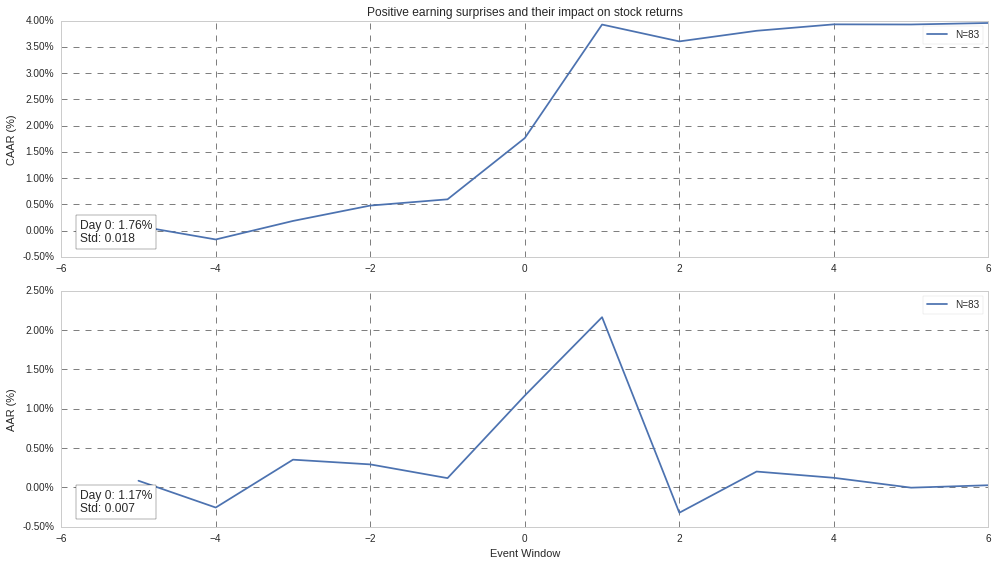

In [10]:
positive_earnings()